# Workshop 2: Detectron2 for object detection

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

In this workshop we will go through some basics usage of detectron2 for object detection

# 0. Download the dataset

1.   Go to [Link to Data](https://public.roboflow.com/object-detection/hard-hat-workers/2) and choose the format COCO JSON
2.   Create an account
3.   Select the Terminal code option
4.   Copy and paste the code below to download the data




In [2]:
!curl -L "https://public.roboflow.com/ds/SOj3LL1YrO?key=hgigVNUjue" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
 extracting: train/002922_jpg.rf.0d24f020d6f688f966ef38c7a0eeba3e.jpg  
 extracting: train/003070_jpg.rf.0d4f1aa374695130ec80a94eb7d3029f.jpg  
 extracting: train/000927_jpg.rf.0c8662a3294885b1dce0b9c9f71bf63d.jpg  
 extracting: train/004334_jpg.rf.0c7c46e2c74725ad2f93e916dc2422dd.jpg  
 extracting: train/000735_jpg.rf.0d5b96188e544511c13ac1e1bfff0b87.jpg  
 extracting: train/001653_jpg.rf.0cc3a72fd244aa7aadee6c4d766190df.jpg  
 extracting: train/004320_jpg.rf.0cedfd83d5055b3a601e711b7e1c149c.jpg  
 extracting: train/002055_jpg.rf.0d0d8e31527f9ca4331834bd0923016e.jpg  
 extracting: train/004879_jpg.rf.0d5c27700ff04fb911be2cc0b0ae7e44.jpg  
 extracting: train/001254_jpg.rf.0cb559668c7f79bc74c9f6b1a276d90d.jpg  
 extracting: train/002336_jpg.rf.0ca4ec6f6ebaabe8df1781814ea731d9.jpg  
 extracting: train/000307_jpg.rf.0da33908e280d7c9d61d7cb6470ecd3f.jpg  
 extracting: train/004239_jpg.rf.0da69bb76e5393015f1e10528419a3fd.jpg

In [3]:
!ls

README.dataset.txt  README.roboflow.txt  sample_data  test  train


In [4]:
from pathlib import Path
import json
import cv2
from matplotlib import pyplot as plt

# 1. Explore data

In [14]:
# Define directories
TRAIN_DIR = Path('train')
TEST_DIR = Path('test')
ANNOTATIONS_TRAIN_PATH = TRAIN_DIR / '_annotations.coco.json'
ANNOTATIONS_TEST_PATH = TEST_DIR / '_annotations.coco.json'

In [15]:
with open(ANNOTATIONS_TRAIN_PATH, 'rb') as f:
  annotations_train = json.load(f)

annotations_train.keys()

dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])

In [16]:
annotations_train['images'][0]

{'id': 0,
 'license': 1,
 'file_name': '002310_jpg.rf.0008cd4590d2edb0e1447329236d9c11.jpg',
 'height': 319,
 'width': 489,
 'date_captured': '2020-04-30T03:26:22+00:00'}

In [8]:
annotations_train['annotations'][1]

{'id': 1,
 'image_id': 0,
 'category_id': 2,
 'bbox': [267, 122, 34, 34],
 'area': 1156,
 'segmentation': [],
 'iscrowd': 0}

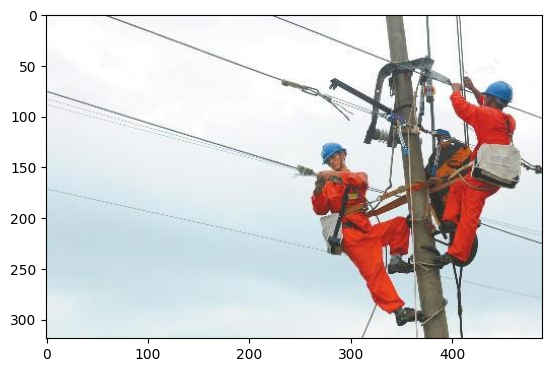

In [9]:
img = cv2.imread('train/002310_jpg.rf.0008cd4590d2edb0e1447329236d9c11.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

# 2. Import data on Detectron2

In [10]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities.
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 20.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyyaml: filename=PyYAML-5.1-cp310-cp310-linux_x86_64.whl size=44090 sha256=a954b9fde56b77e2bbdf3675ca27b2154ae62a6aaa801d73652aad268e28167f
  Stored in directory: /root/.cache/pip/wheels/70/83/31/975b737609aba39a4099d471d5684141c1fdc3404f97e7f68a
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask 2022.12.1 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.
flax 0.6.9 requires PyYAML>=5.4.1, but you have pyyaml 5.1 which is incompatibl

In [11]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog
from detectron2.data.datasets import register_coco_instances

In [12]:
# Register datasets with the format coco: where to get the data from 
register_coco_instances("my_dataset_train", {}, "/content/train/_annotations.coco.json", "/content/train")
register_coco_instances("my_dataset_test", {}, "/content/test/_annotations.coco.json", "/content/test")

WARNING [05/26 15:59:50 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/26 15:59:50 d2.data.datasets.coco]: Loaded 5269 images in COCO format from /content/train/_annotations.coco.json


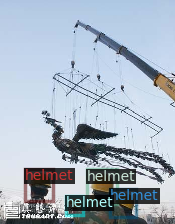

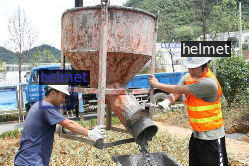

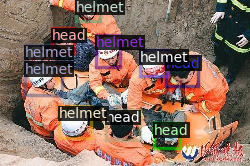

In [13]:
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

# 3. SET MODEL CONFIGURATION

In [18]:
# DOC: https://detectron2.readthedocs.io/en/latest/modules/config.html
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))  # select the faster_rcnn model for object detection
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_test",)

cfg.DATALOADER.NUM_WORKERS = 4    # los números de imagenes que pasan a la vez a la gpu
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4      # batch size
cfg.SOLVER.BASE_LR = 0.001        # learning rate: taza de aprendizaje

cfg.SOLVER.WARMUP_ITERS = 1000    # si lo cambias, no se cambia mucho el resultado, así que dejalo así
cfg.SOLVER.MAX_ITER = 300         # adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = []

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64 # número de cajas que quiero prediccir por cada imagen
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3           # mis clases + 1 

cfg.TEST.EVAL_PERIOD = 300      # como esta funcionandeó en la val

# 4. Train model

In [19]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [ ]:
# Training Process
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train() # si vaja bajando total_loss, todo va bien

[05/26 16:17:54 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
model_final_68b088.pkl: 421MB [00:05, 76.0MB/s]                          
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[05/26 16:18:01 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[05/26 16:19:19 d2.utils.events]:  eta: 0:16:19  iter: 19  total_loss: 1.918  loss_cls: 1.302  loss_box_reg: 0.3898  loss_rpn_cls: 0.1922  loss_rpn_loc: 0.02768    time: 3.4310  last_time: 3.9288  data_time: 0.0426  last_data_time: 0.0038   lr: 6.427e-05  max_mem: 10676M
[05/26 16:20:35 d2.utils.events]:  eta: 0:15:09  iter: 39  total_loss: 1.774  loss_cls: 0.8852  loss_box_reg: 0.8257  loss_rpn_cls: 0.06732  loss_rpn_loc: 0.02736    time: 3.5040  last_time: 3.1957  data_time: 0.0217  last_data_time: 0.0444   lr: 0.00013087  max_mem: 10676M
[05/26 16:21:45 d2.utils.events]:  eta: 0:14:06  iter: 59  total_loss: 1.517  loss_cls: 0.5836  loss_box_reg: 0.8652  loss_rpn_cls: 0.0297  loss_rpn_loc: 0.01853    time: 3.4962  last_time: 3.8927  data_time: 0.0280  last_data_time: 0.0263   lr: 0.00019747  max_mem: 10676M
[05/26 16:22:56 d2.utils.events]:  eta: 0:12:58  iter: 79  total_loss: 1.34  loss_cls: 0.4217  loss_box_reg: 0.8781  loss_rpn_cls: 0.01575  loss_rpn_loc: 0.01752    time: 3.5146  

# 5. Evaluate in test set

In [ ]:
from detectron2.utils.visualizer import ColorMode

In [ ]:
# Load model with the best predictions and its weights
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 # threshold: urbanización típica es 0.5
predictor = DefaultPredictor(cfg)

In [ ]:
# Read images, predict clases of the test dataset and plot them
dataset_dicts = DatasetCatalog.get("my_dataset_test")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=my_dataset_train_metadata, 
                   scale=0.5,
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.data import build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

# Get test metrics
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
inference_on_dataset(trainer.model, val_loader, evaluator)